# KAN vs MLP for Time Series Forecasting

## 1. Import Packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from synthetic import simulate_var
from torch.utils.data import DataLoader, TensorDataset
from models.kan import KAN
from models.model_helper import activation_helper
from tqdm import tqdm

# torch.set_default_dtype(torch.float64)

## 2. Hyperparameters

In [2]:
lag = 5  # number of lags
T = 1000  # number of time points
num_series = 10  # number of time series

batch_size = 32
epochs = 100
lr = 1e-3

dim_input = num_series * lag
dim_output = 1

## 3. Generate Data

In [3]:
# Simulate data with causal relationships
X_np, beta, GC = simulate_var(p=num_series, T=T, lag=lag, sparsity=0.4)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32)  # add one new dimension for X

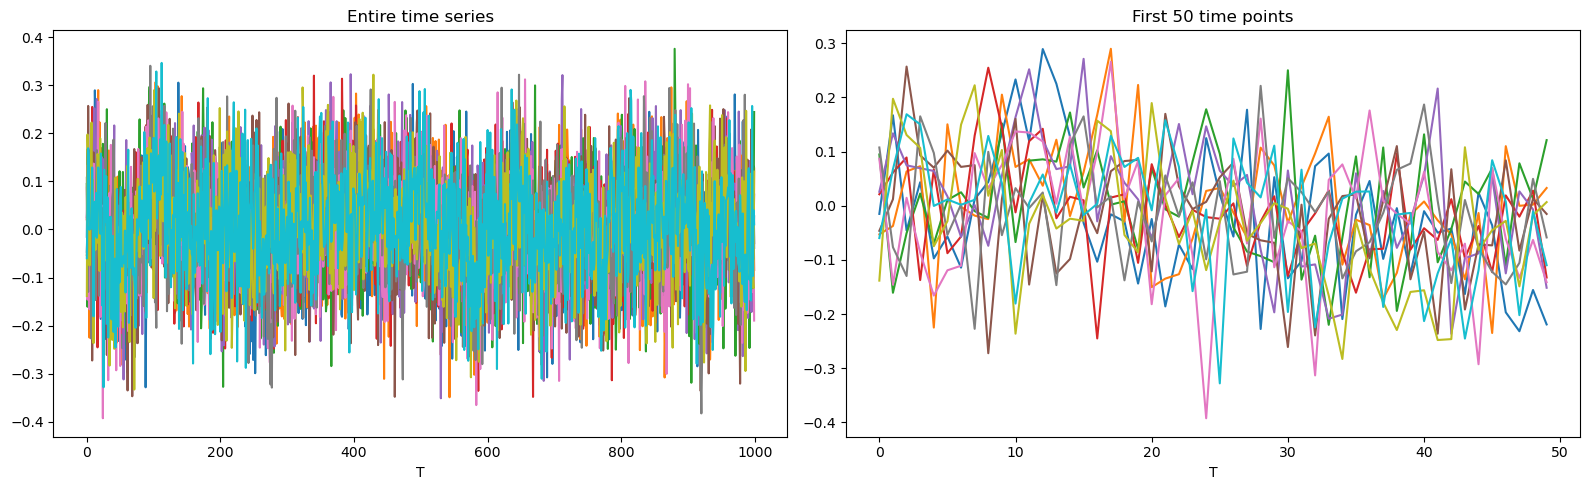

In [4]:
# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(X_np)
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
axarr[1].plot(X_np[:50])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')
plt.tight_layout()
plt.show()

Plot the granger causality among time series

[[1 0 1 1 0 0 0 0 1 0]
 [0 1 1 0 1 0 0 0 1 0]
 [0 0 1 1 1 0 1 0 0 0]
 [0 0 1 1 0 0 0 1 1 0]
 [0 0 0 0 1 1 1 0 1 0]
 [0 0 1 0 0 1 0 0 1 1]
 [1 1 0 0 0 0 1 0 0 1]
 [0 1 1 1 0 0 0 1 0 0]
 [0 0 0 1 0 1 0 0 1 1]
 [0 1 0 0 1 1 0 0 0 1]]


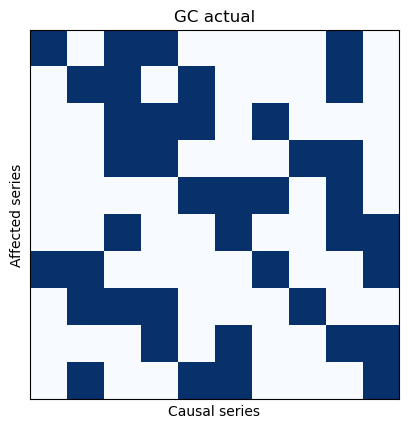

In [5]:
print(GC)

plt.imshow(GC, cmap='Blues')
plt.title('GC actual')
plt.ylabel('Affected series')
plt.xlabel('Causal series')
plt.xticks([])
plt.yticks([])
# plt.colorbar()
plt.show()

## 4. Prepare the Data

- In this section, we choose TS1 as the target time series.

- The lags of the rest 4 series and TS1 itself will be used to predict the current value of TS1.

- For TS1, it is affected by TS0, TS1, TS3.

In [6]:
target_series = 1  # the series we want to predict

In [7]:
def pd_data(X):
    '''
    Use dataframe to show the data structure
    Y: target series
    ts{}_lag{}: value of time series {} with lag {}
    '''
    Y = X[:, :, target_series]
    df = pd.DataFrame({'Y': Y[0,:].detach().numpy()})[lag:]
    for i in range(num_series):
        for j in range(lag):
            df['ts{}_lag{}'.format(i, lag-j)] = X[0, :, i].detach().numpy()[j:-lag+j]
    return df

def rearrange_data(X):
    '''
    Rearrange the time series, to form a data with lags

    Input:
        X: tensor with shape (1, num_series, T)
    Output:
        array: tensor with shape (num_series * lag, T-lag)
    '''
    li = []
    for i in range(num_series):
        for j in range(lag):
            li.append(X[0, :, i].detach().numpy()[j:-lag+j])

    # transfer li to tensor
    array = torch.tensor(li, dtype=torch.float32)

    return array

In [8]:
array = rearrange_data(X).T
print(array.shape)

Y = X[:, :, target_series][0, :T-lag].reshape(1, T-lag).T
print(Y.shape)

# Show the data structure using dataframe
# pd_data(X)

# put the data into DataLoader
trainloader = DataLoader(TensorDataset(array, Y), batch_size=32, shuffle=True)

torch.Size([995, 50])
torch.Size([995, 1])


/var/folders/yl/m5cgc23j1gbfcvxxglrgsk0w0000gn/T/ipykernel_84680/389140576.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_9d63z49rj_/croot/pytorch_1681837279022/work/torch/csrc/utils/tensor_new.cpp:233.)
  array = torch.tensor(li, dtype=torch.float32)


## 5. Predict using KAN

### 5.1 Explore how the layer width can affect the result. (Depth=1)

In [9]:
layers = [4, 8, 16]
kan_loss_width_all = []
kan_output_width_all = []

for layer in layers:
    model = KAN([dim_input, layer, dim_output], spline_order=5)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    kan_loss = []
    print("-" * 10)
    print("Hidden layer number: ", layer)

    for epoch in range(epochs):
        # Train
        model.train()
        for i, data in enumerate(trainloader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
        kan_loss.append(loss.item())
        if (epoch+1) % 10 == 0:
            print('Epoch: {}, loss: {}'.format(epoch + 1, loss.item()))
    
    kan_output_width_all.append(model(array).detach().numpy())
    kan_loss_width_all.append(kan_loss)

----------
Hidden layer number:  4
Epoch: 10, loss: 0.00010117800411535427
Epoch: 20, loss: 3.879978976328857e-06
Epoch: 30, loss: 8.861637070367578e-06
Epoch: 40, loss: 7.428691333188908e-06
Epoch: 50, loss: 8.4977267533759e-07
Epoch: 60, loss: 7.34812090286141e-07
Epoch: 70, loss: 6.338497314573033e-06
Epoch: 80, loss: 3.677131871882011e-06
Epoch: 90, loss: 2.071965127470321e-06
Epoch: 100, loss: 3.2176985769183375e-06
----------
Hidden layer number:  8
Epoch: 10, loss: 1.4699402527185157e-05
Epoch: 20, loss: 4.083739440829959e-06
Epoch: 30, loss: 7.802805157552939e-06
Epoch: 40, loss: 4.428271950018825e-06
Epoch: 50, loss: 1.0586422831693199e-06
Epoch: 60, loss: 1.4624719142375397e-06
Epoch: 70, loss: 2.1498910882655764e-06
Epoch: 80, loss: 6.866806415928295e-06
Epoch: 90, loss: 1.1890840596606722e-06
Epoch: 100, loss: 2.6817997422767803e-06
----------
Hidden layer number:  16
Epoch: 10, loss: 7.288269898708677e-06
Epoch: 20, loss: 4.842009730054997e-06
Epoch: 30, loss: 1.3050516827

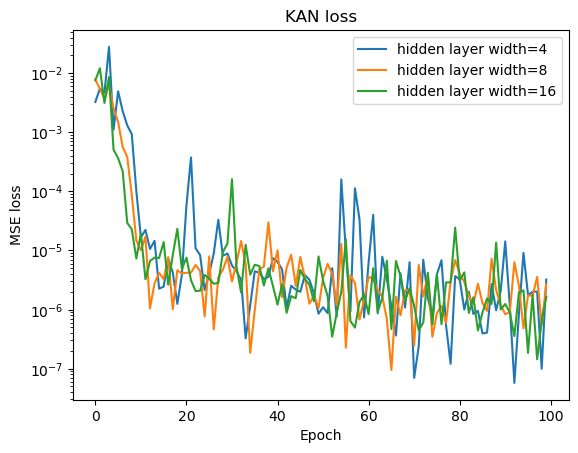

In [10]:
for i, kan_loss in enumerate(kan_loss_width_all):
    plt.plot(kan_loss, label='hidden layer width={}'.format(layers[i]))
    # log scale 
    plt.yscale('log')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('MSE loss')
    plt.title('KAN loss')
plt.show()

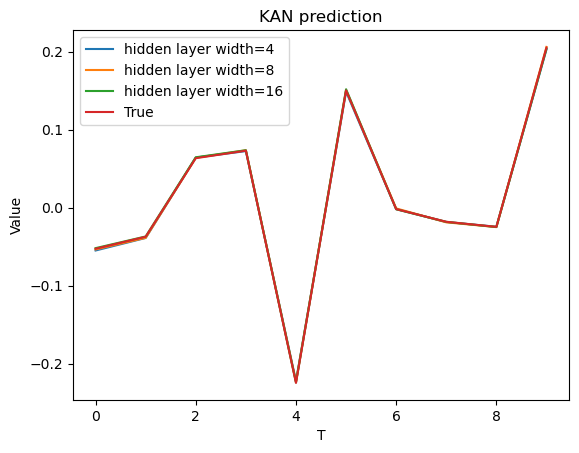

In [11]:
for i, kan_output in enumerate(kan_output_width_all):
    plt.plot(kan_output[:10], label='hidden layer width={}'.format(layers[i]))
plt.plot(Y[:10], label='True')
plt.legend()
plt.xlabel('T')
plt.ylabel('Value')
plt.title('KAN prediction')
plt.show()

### 5.2 Explore how layer depth can affect the result. (Width=4)

In [12]:
layers = [
    [dim_input, 4, dim_output],
    [dim_input, 4, 4, dim_output],
    [dim_input, 4, 4, 4, dim_output]
]
kan_loss_depth_all = []
kan_output_depth_all = []

for i, layer in enumerate(layers):
    model = KAN(layer)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    kan_loss = []
    print("-" * 10)
    print("Hidden layer depth: ", i+1)

    for epoch in range(epochs):
        # Train
        model.train()
        for i, data in enumerate(trainloader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
        kan_loss.append(loss.item())
        if (epoch+1) % 10 == 0:
            print('Epoch: {}, loss: {}'.format(epoch + 1, loss.item()))
    
    kan_output_depth_all.append(model(array).detach().numpy())
    kan_loss_depth_all.append(kan_loss)

----------
Hidden layer depth:  1
Epoch: 10, loss: 8.284192881546915e-05
Epoch: 20, loss: 6.778124316042522e-06
Epoch: 30, loss: 5.053338441030064e-07
Epoch: 40, loss: 1.3175278581911698e-05
Epoch: 50, loss: 1.3028049579588696e-05
Epoch: 60, loss: 3.957855824410217e-06
Epoch: 70, loss: 1.8827136045729276e-06
Epoch: 80, loss: 2.300201003890834e-06
Epoch: 90, loss: 9.137963274952199e-07
Epoch: 100, loss: 6.273292569858313e-07
----------
Hidden layer depth:  2
Epoch: 10, loss: 9.898838470689952e-06
Epoch: 20, loss: 5.635320121655241e-06
Epoch: 30, loss: 4.100519674921088e-07
Epoch: 40, loss: 1.119610260502668e-06
Epoch: 50, loss: 1.8215413319921936e-06
Epoch: 60, loss: 7.783239652781049e-07
Epoch: 70, loss: 1.2814692240681325e-07
Epoch: 80, loss: 1.7414812703009375e-07
Epoch: 90, loss: 3.789870959280961e-07
Epoch: 100, loss: 1.009393031381478e-06
----------
Hidden layer depth:  3
Epoch: 10, loss: 4.095141412108205e-05
Epoch: 20, loss: 7.489084055123385e-07
Epoch: 30, loss: 7.9763623261897

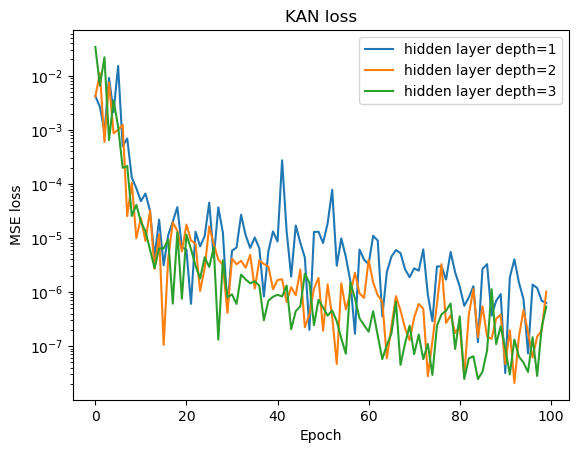

In [13]:
for i, kan_loss in enumerate(kan_loss_depth_all):
    plt.plot(kan_loss, label='hidden layer depth={}'.format(i+1))
    # log scale 
    plt.yscale('log')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('MSE loss')
    plt.title('KAN loss')
plt.show()

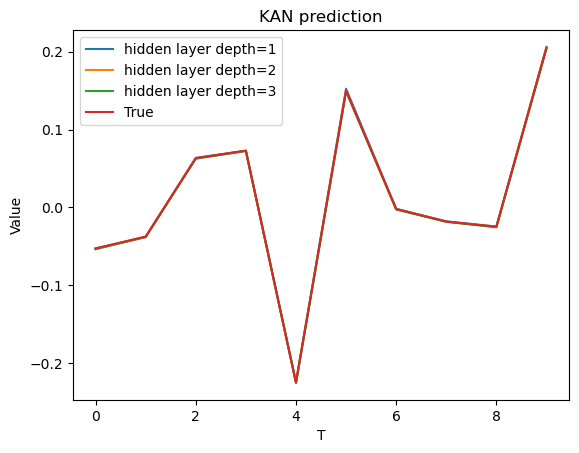

In [14]:
for i, kan_output in enumerate(kan_output_depth_all):
    plt.plot(kan_output[:10], label='hidden layer depth={}'.format(i+1))
plt.plot(Y[:10], label='True')
plt.legend()
plt.xlabel('T')
plt.ylabel('Value')
plt.title('KAN prediction')
plt.show()

## 6. Predict using MLP

In [15]:
class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            if i != len(layers) - 2:
                self.layers.append(activation_helper('relu'))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [16]:
layers = [4, 8, 16]
mlp_loss_all = []
mlp_output_all = []

for layer in layers:
    model = MLP([dim_input, layer, dim_output])
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    mlp_loss = []
    print("-" * 10)
    print("Hidden layer number: ", layer)

    for epoch in range(epochs):
        # Train
        model.train()
        for i, data in enumerate(trainloader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
        mlp_loss.append(loss.item())
        if (epoch+1) % 5 == 0:
            print('Epoch: {}, loss: {}'.format(epoch + 1, loss.item()))
    
    mlp_output_all.append(model(array).detach().numpy())
    mlp_loss_all.append(mlp_loss)

----------
Hidden layer number:  4
Epoch: 5, loss: 0.01680583693087101
Epoch: 10, loss: 0.0003801987040787935
Epoch: 15, loss: 0.0011815805919468403
Epoch: 20, loss: 0.0009804535657167435
Epoch: 25, loss: 0.00016554650210309774
Epoch: 30, loss: 9.45390565902926e-05
Epoch: 35, loss: 6.756186394341057e-06
Epoch: 40, loss: 6.020347314006358e-07
Epoch: 45, loss: 5.883085759705864e-05
Epoch: 50, loss: 6.256154847505968e-07
Epoch: 55, loss: 8.320395750160969e-07
Epoch: 60, loss: 7.945311040202796e-07
Epoch: 65, loss: 3.6461025842982053e-07
Epoch: 70, loss: 1.5904568329005997e-07
Epoch: 75, loss: 1.493710101385659e-06
Epoch: 80, loss: 5.393605988501804e-07
Epoch: 85, loss: 1.5224050287088176e-07
Epoch: 90, loss: 3.3643797792137775e-07
Epoch: 95, loss: 1.7074872857847367e-06
Epoch: 100, loss: 2.0495657793162536e-07
----------
Hidden layer number:  8
Epoch: 5, loss: 0.0024736670311540365
Epoch: 10, loss: 0.00025323868612758815
Epoch: 15, loss: 9.600894554750994e-05
Epoch: 20, loss: 8.7995176727

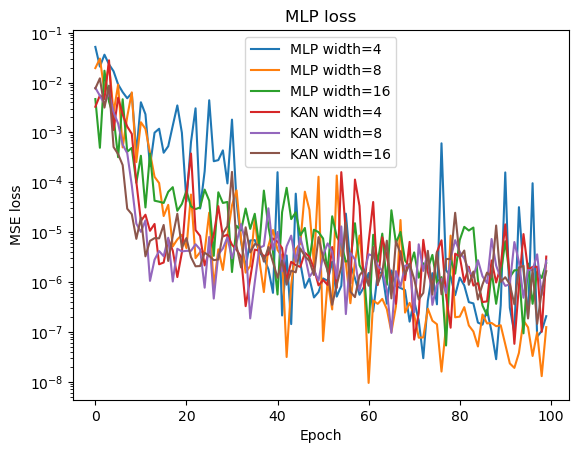

In [17]:
for i, mlp_loss in enumerate(mlp_loss_all):
    plt.plot(mlp_loss, label='MLP width={}'.format(layers[i]))
for i, kan_loss in enumerate(kan_loss_width_all):
    plt.plot(kan_loss, label='KAN width={}'.format(layers[i]))
# log scale 
plt.yscale('log')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('MLP loss')
plt.show()